In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict
import cv2

# imagens
PATH = 'C:\\Users\\marco\\Google Drive\\ComputerScience\\Visão Computacional\\images\\'

def SIFT(imgs, keys):
    sift = cv2.SIFT_create()

    kpts = OrderedDict()
    features = OrderedDict()

    for key in keys:
        kpts[key], features[key] = sift.detectAndCompute(imgs[key], None)

    return kpts, features

def matcher(features_A, features_B):
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    best_matches = bf.match(features_A, features_B)
    rawMatches = sorted(best_matches, key=lambda x:x.distance)
    return rawMatches

def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [2]:
imgs = OrderedDict()
imgsGray = OrderedDict()
keys = ['0_45L', '0_0', '0_45R', '1_45L', '1_0', '1_45R']

for k in keys:
    imgs[k] = plt.imread(f'{PATH}{k}.jpg')
    imgsGray[k] = cv2.cvtColor(imgs[k], cv2.COLOR_RGB2GRAY)

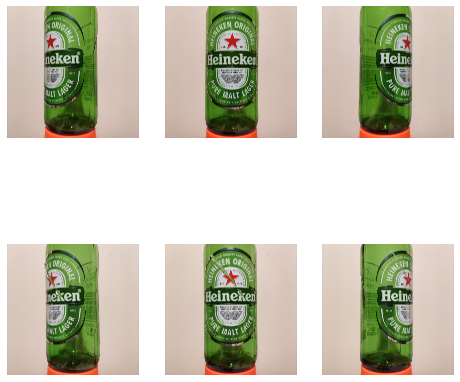

In [3]:
nrow = 2
ncol = 3
fig, ax = plt.subplots(nrow, ncol, figsize=(8, 8))
for i in range(nrow):
    for j in range(ncol):
        k = keys[i * ncol + j]
        ax[i, j].imshow(imgs[k])
        ax[i, j].axis('off')
plt.show()

In [4]:
kpts, features = SIFT(imgsGray, keys)

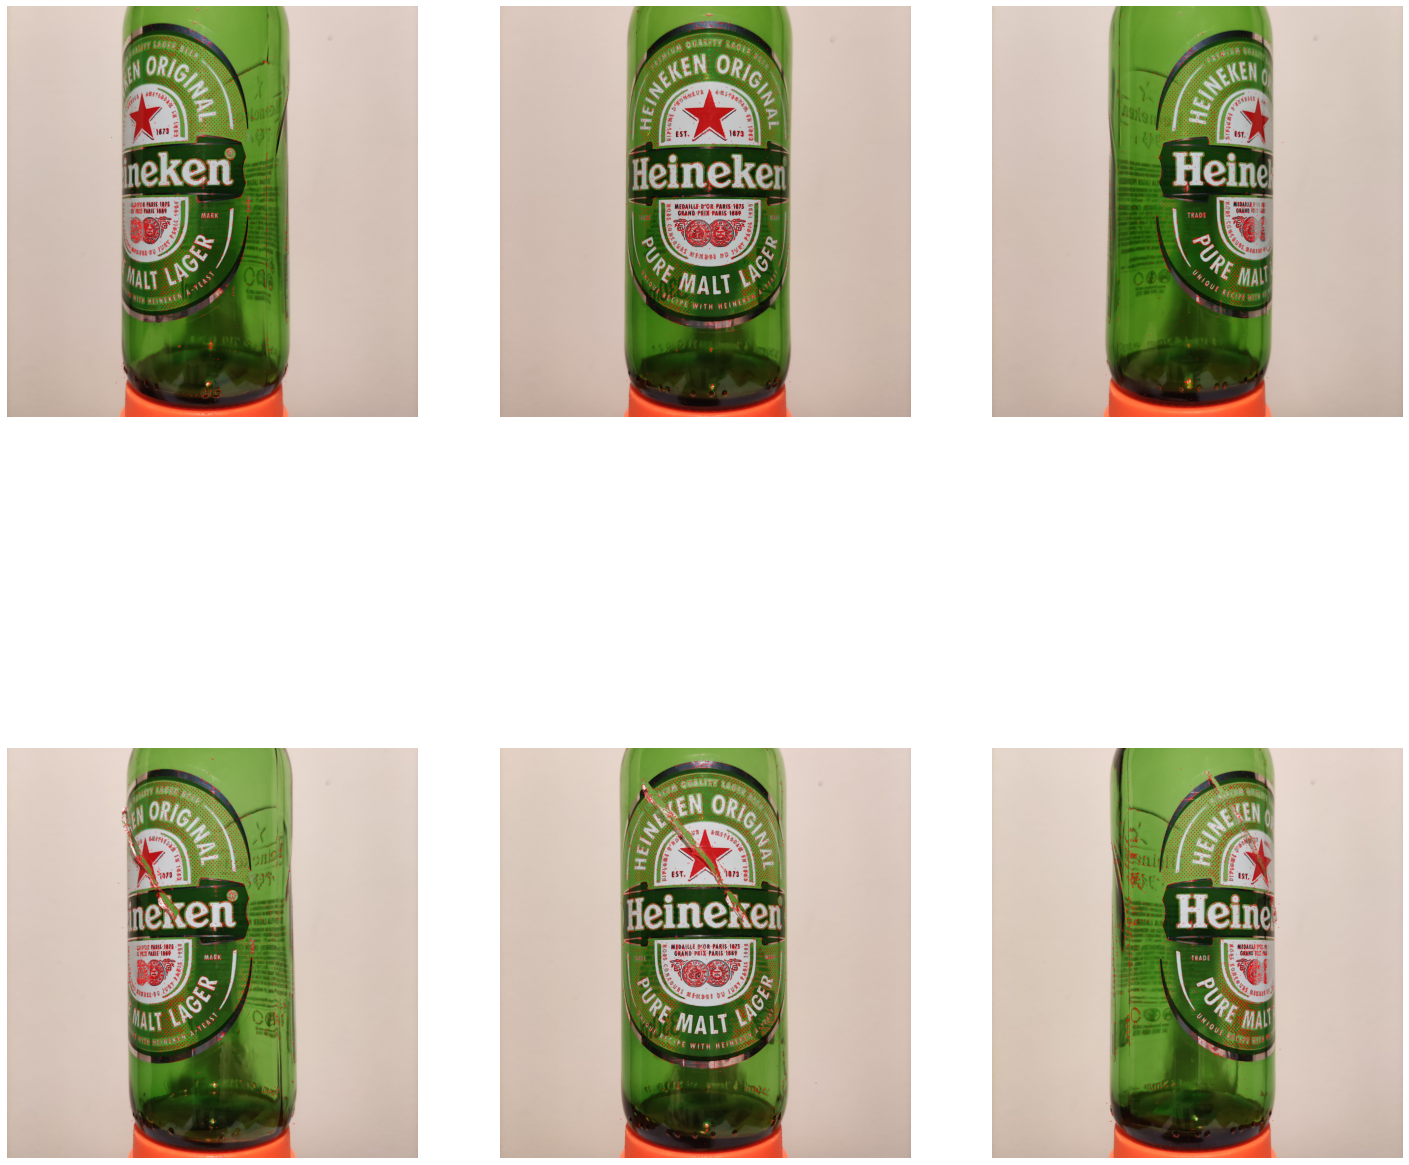

In [5]:
fig, ax = plt.subplots(nrow, ncol, figsize=(25, 25))
for i in range(nrow):
    for j in range(ncol):
        k = keys[i * ncol + j]
        ax[i, j].imshow(cv2.drawKeypoints(imgs[k], kpts[k],
                                         None, color=(255, 0, 0)))
        ax[i, j].axis('off')
plt.show()

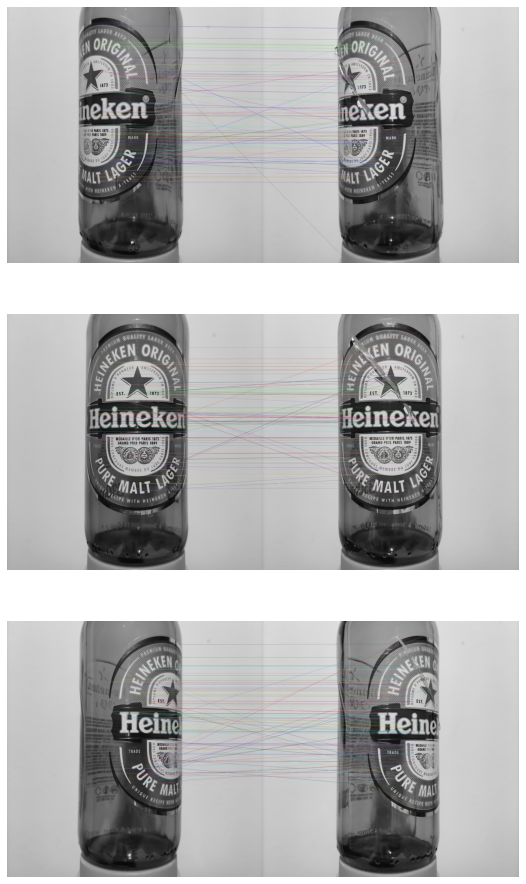

In [6]:
matches = OrderedDict()
imgs_match = OrderedDict()
fig, ax = plt.subplots(3, 1, figsize=(16, 16))
for i in range(len(keys) // 2):
    A = keys[i]
    B = keys[i + len(keys) // 2]
    k = f'{A}___{B}'
    matches[k] = matcher(features[A], features[B])
    
    imgs_match[k] = cv2.drawMatches(imgsGray[A], kpts[A],
                                   imgsGray[B], kpts[B],
                                   matches[k][:100], None,
                                   flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    ax[i].imshow(imgs_match[k])
    ax[i].axis('off')
plt.show()

In [7]:
H = OrderedDict()
for i in range(len(keys) // 2):
    A = keys[i]
    B = keys[i + len(keys) // 2]
    k = f'{A}___{B}'
    
    M = getHomography(kpts[A], kpts[B],
                      features[A], features[B],
                      matches[k], reprojThresh=4)
    (matches_, H[k], status_) = M
    print(H[k])

[[ 9.51088626e-01  5.49900422e-03  5.93605472e+01]
 [-2.65156543e-02  9.65932091e-01  6.97698108e+01]
 [-9.49922283e-06 -2.22737662e-06  1.00000000e+00]]
[[ 1.10353571e+00  1.48820247e-02 -1.20859775e+02]
 [ 3.78684352e-02  1.05864409e+00 -6.81876554e+01]
 [ 3.25268531e-05  4.33237050e-06  1.00000000e+00]]
[[ 1.08976621e+00  7.18190612e-03 -5.02254669e+01]
 [ 2.79984719e-02  1.06339554e+00 -5.70357971e+01]
 [ 2.64344551e-05  2.18981416e-06  1.00000000e+00]]


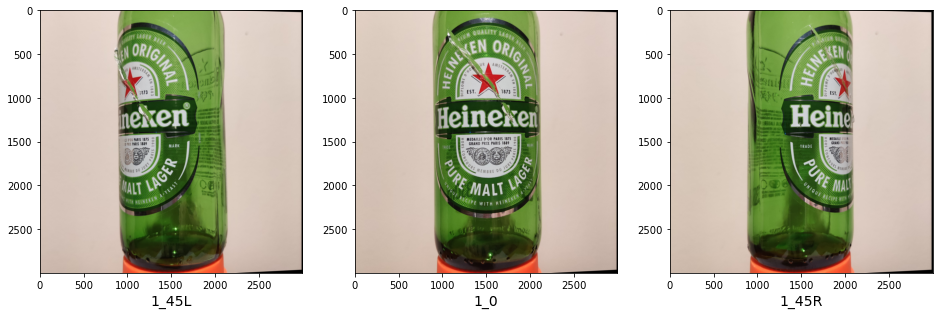

In [8]:
results = OrderedDict()
resultsGray = OrderedDict()
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
for i in range(len(keys) // 2):
    A = keys[i]
    B = keys[i + len(keys) // 2]
    
    width = imgs[A].shape[1]
    height = imgs[A].shape[0]
    results[B] = cv2.warpPerspective(imgs[B], H[k], (width, height))
    resultsGray[B] = cv2.cvtColor(results[B], cv2.COLOR_RGB2GRAY)
    
    ax[i].imshow(results[B])
    ax[i].set_xlabel(B, fontsize=14)
plt.show()

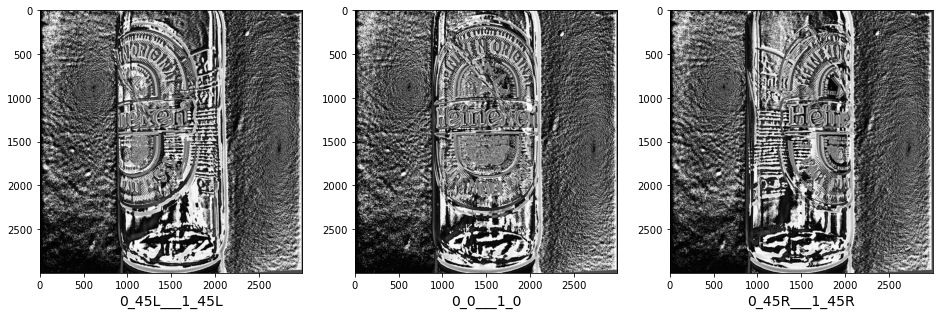

In [9]:
diff = OrderedDict()
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
for i in range(len(keys) // 2):
    A = keys[i]
    B = keys[i + len(keys) // 2]
    k = f'{A}___{B}'
    
    diff[k] = resultsGray[B] - imgsGray[B] 
    
    ax[i].imshow(diff[k], 'gray')
    ax[i].set_xlabel(k, fontsize=14)
plt.show()

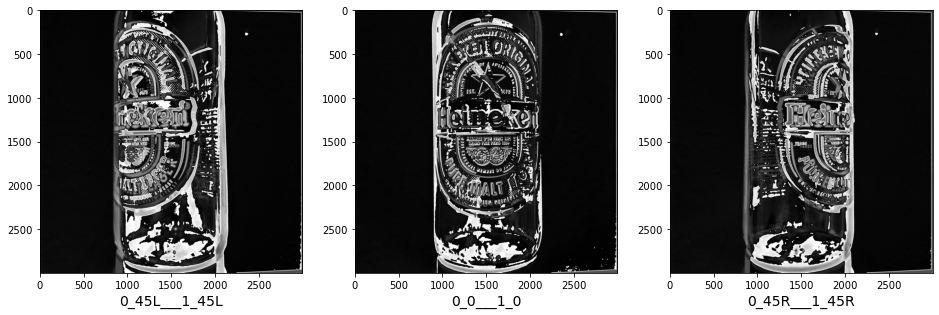

In [10]:
diffSmooth = OrderedDict()
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
for i in range(len(keys) // 2):
    A = keys[i]
    B = keys[i + len(keys) // 2]
    k = f'{A}___{B}'
    
    imgA = cv2.GaussianBlur(imgsGray[A], (11, 11), cv2.BORDER_DEFAULT)
    imgB = cv2.GaussianBlur(resultsGray[B], (11, 11), cv2.BORDER_DEFAULT)
    diffSmooth[k] = imgB - imgA
    
    ax[i].imshow(diffSmooth[k], 'gray')
    ax[i].set_xlabel(k, fontsize=14)
plt.show()

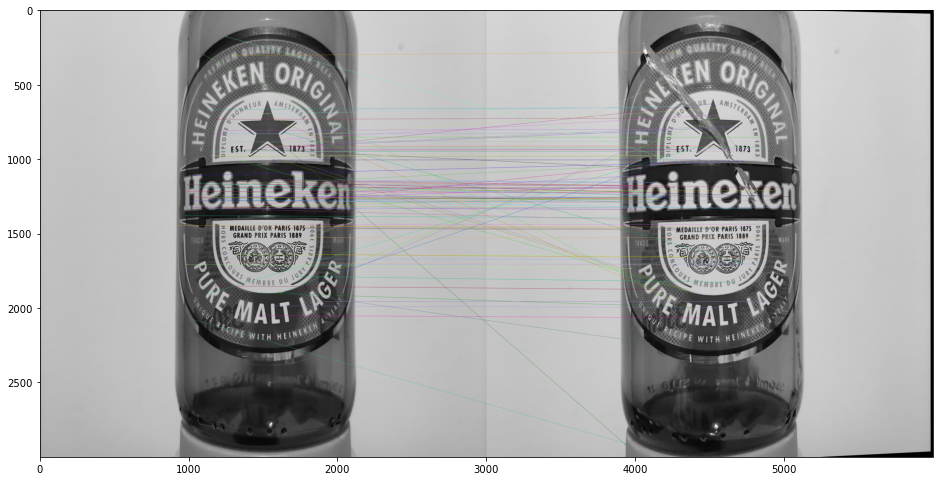

In [11]:
imgA = imgsGray['0_0']
imgB = resultsGray['1_0']

sift = cv2.SIFT_create()
kptsA, descriptorsA = sift.detectAndCompute(imgA, None)
kptsB, descriptorsB = sift.detectAndCompute(imgB, None)

matches = matcher(descriptorsA, descriptorsB)

imgMatch = cv2.drawMatches(imgA, kptsA,
                             imgB, kptsB,
                             matches[:100], None,
                             flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(16, 9))
plt.imshow(imgMatch)
plt.show()